### Dim Configuration
input x : 1 x n_samples 


u = conv(x-k : x+k)


output y : 1 x n_samples

### Generate Data

In [225]:
### generate data
import numpy as np
np.random.seed(5)


def  Convolution(X, k, ConvW):
    """
    k is and odd number
    :param X: 1 x k, center is the current state
    :param k: kernel size
    :param ConvW: 1 x k

    :return: 1 x n_samples
    """

    y = np.zeros(1)

    for i in range(k):

        y += (ConvW[i] * X[i])[0]

    return y

def generate_data(n_samples, true_coefficients, noise_level=0.1):

    # Generate a random input signal
    k = len(true_coefficients)
    m, n = true_coefficients[0].shape

    x = np.random.randn(n_samples, m) 

    # Generate the desired signal by passing the input through the known system
    y = np.zeros((n_samples,n)) 

    for i  in range(k//2, n_samples- k // 2):
        y[i] = Convolution(x[i-k//2 : i + k//2 + 1], k, true_coefficients.flatten())[0]
    
    # Add some noise
    y += noise_level * np.random.randn(n_samples, n)
    
    
    return x, y

# Example usage
n_samples = 200
# a series of matrix: k x m x n 
# k : influence scope 
# m : output dimension  
# n : input dimension 

k = 7
m = 1
n = 1
True_coefficients = np.array([np.random.randn(m,n) for _ in range(k)])
# True_coefficients = np.array([[[1]] for _ in range(k)])
noise_level = 0.1
x, y = generate_data(n_samples, True_coefficients, noise_level)
print("Input signal:", x[:3])
print("Desired signal:", y[:3])

Input signal: [[-0.59163666]
 [ 0.18760323]
 [-0.32986996]]
Desired signal: [[ 0.02120433]
 [-0.03679446]
 [ 0.21114884]]


### Kalman Filter

In [226]:
### using kalman filter to estimate the coefficients
def kalman_filter(x, y, k,epoch):
    n_samples, m = x.shape
    n = y.shape[1]
    
    # Initialize the state estimate
    # Initialize w: k x m x n randomly\
    ErrorRecord  = []
    CoefRecord = []
    w = np.ones((k))
    ### prerecord 
        ### calcualte total error 
    Error = 0
    for j in range(k // 2, n_samples - k // 2):
        e = (y[j] - Convolution(x[j - k // 2 :  j + k//2 + 1], k, w) ) **2
        Error += e
    ErrorRecord.append(Error)
    CoefRecord.append(w)

    # PQR matrices, initialized as identity matrices, each one is k,k
    P = np.array(np.eye(k,k))
    # Q = np.array([np.eye(m*n) for _ in range(k)]) * 0.01
    R = np.array(np.eye(1,1)) * 1
    

    for _ in range(epoch):
        for i in range(k//2 , n_samples - k//2):
            # Predict_state
            w = w
            P = P

            # Update_state
            ## error 
            y_hat = Convolution(x[i - k//2 : i + k//2 + 1], k, w)
            e = y[i] - y_hat

            ## Kalman Gain
            H_temp = x[i-k//2 : i + k//2 + 1].reshape(1,-1)
            S = np.dot(H_temp, np.dot(P, H_temp.T)) + R
            K = np.dot(P, np.dot(H_temp.T, np.linalg.inv(S)))

            w = w + np.dot(K, e)
            P = (np.eye(k) - K @ H_temp) @ P
            


            if i % 10 == 0:
                ### calcualte total error 
                Error = 0
                for j in range(k // 2, n_samples - k // 2):
                    e = (y[j] - Convolution(x[j - k // 2 :  j + k//2 + 1], k, w) ) **2
                    Error += e
                ErrorRecord.append(Error)
                CoefRecord.append(w)

    return w, ErrorRecord, CoefRecord

### Example Usage

In [227]:
Estimated_coefficients, ErrorRecord,CoefRecord = kalman_filter(x, y, k,epoch= 1)

In [228]:
print("True coefficients:", True_coefficients.reshape(-1))
print("Estimated coefficients:", Estimated_coefficients)

True coefficients: [ 0.44122749 -0.33087015  2.43077119 -0.25209213  0.10960984  1.58248112
 -0.9092324 ]
Estimated coefficients: [ 0.4300306  -0.31998069  2.41613259 -0.24374908  0.1108373   1.58090669
 -0.89395049]


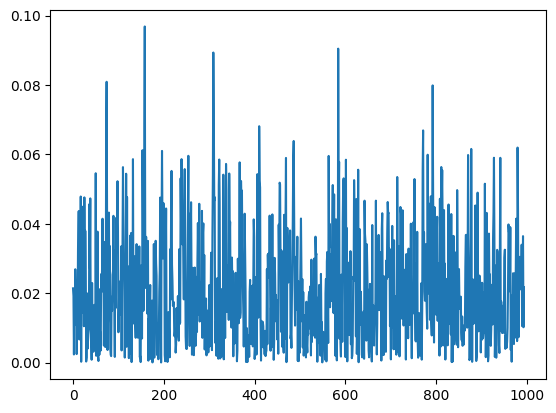

In [229]:
np.random.seed(10)
x_test = np.random.randn(1000, 1) 

### plot error 
import matplotlib.pyplot as plt
TestErrorRecord = []
for i in range(k//2, len(x_test)- k // 2):
    y_test = Convolution(x_test[i-k//2 : i + k//2 + 1], k, True_coefficients.flatten())
    y_hat = Convolution(x_test[i-k//2 : i + k//2 + 1], k, Estimated_coefficients)
    TestErrorRecord.append(np.linalg.norm(y_test - y_hat))
plt.plot(TestErrorRecord)
plt.show()

### Plot the error

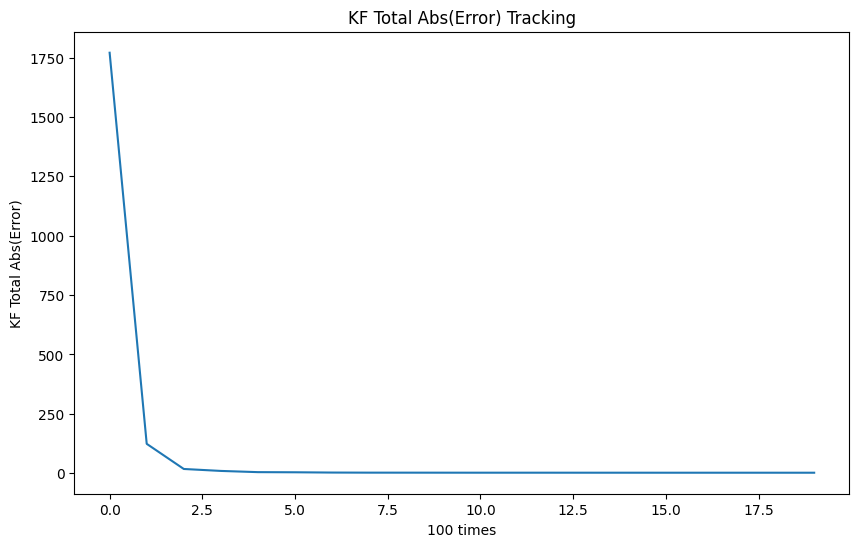

In [230]:
import matplotlib.pyplot as plt
### set fig size
plt.figure(figsize=(10, 6))
plt.plot(ErrorRecord)
plt.xlabel("100 times")
plt.ylabel("KF Total Abs(Error)")
plt.title("KF Total Abs(Error) Tracking")
### save the plot
plt.savefig("KF_total_error.png", dpi=300)
plt.show()


In [231]:
ErrorRecord[-1]

array([1.86531774])

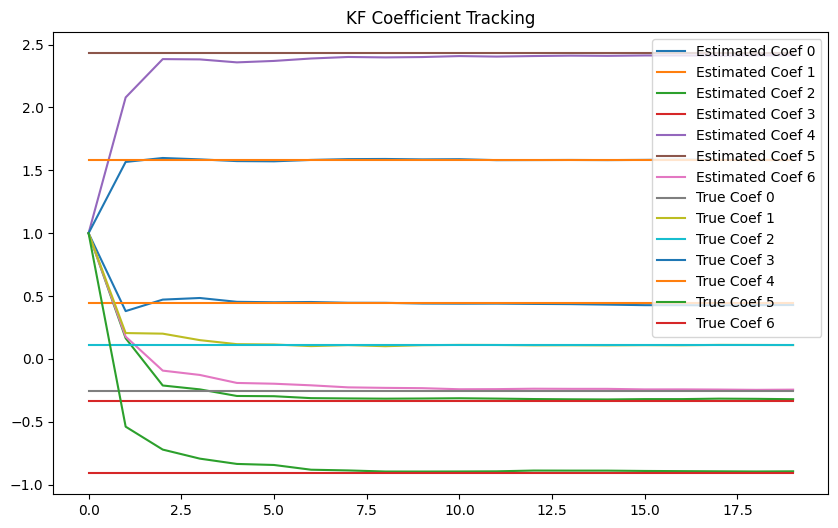

In [232]:
### Plot the Coefficient tracking plot and ground truth(each a line )
CoefRecord = np.array(CoefRecord)
### set fig size
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.plot(CoefRecord[:,i])
    plt.plot(np.array([True_coefficients[i] for _ in range(len(CoefRecord))]).reshape(-1))

plt.legend(["Estimated Coef %d" % i for i in range(k)] + ["True Coef %d" % i for i in range(k)])
plt.title("KF Coefficient Tracking")
### save the plot
plt.savefig("KF_Coef_Tracking.png", dpi=300)
plt.show()
